In [1]:
import sys
import csv
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import sexmachine.detector as gender
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
get_ipython().magic(u'matplotlib inline')

In [2]:
def read_datasets():
    """ Reads users profile from csv files """
    genuine_users = pd.read_csv("data/users.csv")
    fake_users = pd.read_csv("data/fusers.csv")
    x=pd.concat([genuine_users,fake_users])   
    y=len(fake_users)*[0] + len(genuine_users)*[1]
    return x,y

In [3]:
def predict_sex(name):
    sex_predictor = gender.Detector(unknown_value=u"unknown",case_sensitive=False)
    first_name= name.str.split(' ').str.get(0)
    sex= first_name.apply(sex_predictor.get_gender)
    sex_dict={'female': -2, 'mostly_female': -1,'unknown':0,'mostly_male':1, 'male': 2}
    sex_code = sex.map(sex_dict).astype(int)
    return sex_code

In [4]:
def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))   
    lang_dict = { name : i for i, name in lang_list }             
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)    
    x.loc[:,'sex_code']=predict_sex(x['name'])
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
    x=x.loc[:,feature_columns_to_use]
    return x

In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [6]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    print "False Positive rate: ",false_positive_rate
    print "True Positive rate: ",true_positive_rate


    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [15]:
def trainGradientBoosting(X_train,y_train,X_test):
    """ Trains and predicts dataset with an GradientBoosting classifier """
    
    clf4=GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=120, min_impurity_decrease=0.0, random_state=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)
    clf4.fit(X_train,y_train)
    score4 = clf4.score(X_test,y_test)
    print("The best classifier is: ",clf4)
    # Estimate score
    scores4 = cross_val_score(clf4, X_train,y_train, cv=5)
    print score4
    print('Estimated score: %0.5f (+/- %0.5f)' % (score4.mean(), score4.std() / 2))
    title = 'Learning Curves (GradientBoosting)'
    plot_learning_curve(clf4, title, X_train, y_train, cv=5)
    plt.show()
    # Predict 
    y_pred = clf4.predict(X_test)
    return y_test,y_pred

In [16]:
print "reading datasets.....\n"
x,y=read_datasets()

reading datasets.....



In [17]:
print "extracting featues.....\n"
x=extract_features(x)
print x.columns
print x.describe()

extracting featues.....

Index([u'statuses_count', u'followers_count', u'friends_count',
       u'favourites_count', u'listed_count', u'sex_code', u'lang_code'],
      dtype='object')
       statuses_count  followers_count  friends_count  favourites_count  \
count     2818.000000      2818.000000    2818.000000       2818.000000   
mean      1672.198368       371.105039     395.363023        234.541164   
std       4884.669157      8022.631339     465.694322       1445.847248   
min          0.000000         0.000000       0.000000          0.000000   
25%         35.000000        17.000000     168.000000          0.000000   
50%         77.000000        26.000000     306.000000          0.000000   
75%       1087.750000       111.000000     519.000000         37.000000   
max      79876.000000    408372.000000   12773.000000      44349.000000   

       listed_count     sex_code    lang_code  
count   2818.000000  2818.000000  2818.000000  
mean       2.818666    -0.180270     2.85131

In [18]:
print "spliting datasets in train and test dataset...\n"
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.20, random_state=44)

spliting datasets in train and test dataset...



training datasets.......

('The best classifier is: ', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=120,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))
0.9397163120567376
Estimated score: 0.93972 (+/- 0.00000)


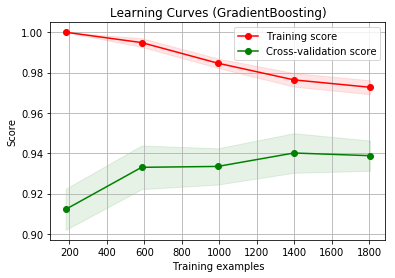

In [20]:
print "training datasets.......\n"
y_test,y_pred = trainGradientBoosting(X_train,y_train,X_test)

In [21]:
print 'Classification Accuracy on Test dataset: ' ,accuracy_score(y_test, y_pred)

Classification Accuracy on Test dataset:  0.9397163120567376


Confusion matrix, without normalization
[[262   6]
 [ 28 268]]


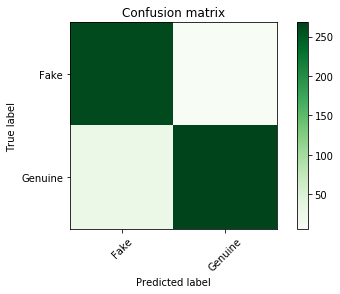

In [22]:
cm=confusion_matrix(y_test, y_pred)
print('Confusion matrix, without normalization')
print(cm)
plot_confusion_matrix(cm)

Normalized confusion matrix
[[0.97761194 0.02238806]
 [0.09459459 0.90540541]]


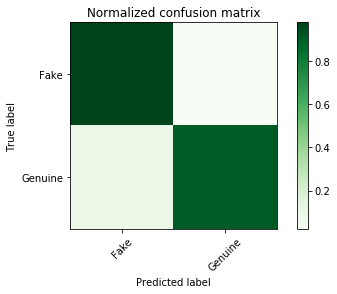

In [23]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

In [24]:
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))

              precision    recall  f1-score   support

        Fake       0.90      0.98      0.94       268
     Genuine       0.98      0.91      0.94       296

   micro avg       0.94      0.94      0.94       564
   macro avg       0.94      0.94      0.94       564
weighted avg       0.94      0.94      0.94       564



False Positive rate:  [0.         0.02238806 1.        ]
True Positive rate:  [0.         0.90540541 1.        ]


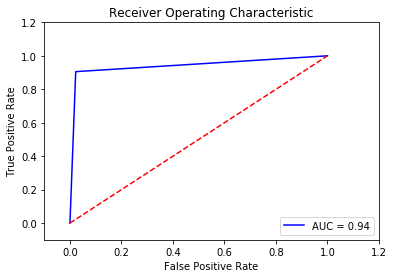

In [25]:
plot_roc_curve(y_test, y_pred)